In [1]:
# imports
from preprocessing import prepare_dataset
from engine import model_eval
import helper_functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nop

## 0. Preprocessing

In [2]:
X_template, y_template = prepare_dataset(data_dir="data/",
                                      features="Standard")

Batches:   0%|          | 0/579 [00:00<?, ?it/s]

2023-10-25 00:06:13,235 - BERTopic - Transformed documents to Embeddings
/home/egor/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
2023-10-25 00:06:55,932 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-10-25 00:07:55,903 - BERTopic - Clustered reduced embeddings


In [3]:
X_improved, y_improved = prepare_dataset(data_dir="data/",
                                      features="Improved")

Article Mapping:   0%|          | 0/18520 [00:00<?, ?it/s]

## 1. Model Investigation

### 1.1 Template model

/home/egor/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     258.4
Date:                Wed, 25 Oct 2023   Prob (F-statistic):          4.40e-196
Time:                        00:11:27   Log-Likelihood:                -298.28
No. Observations:                 962   AIC:                             610.6
Df Residuals:                     955   BIC:                             644.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8493 

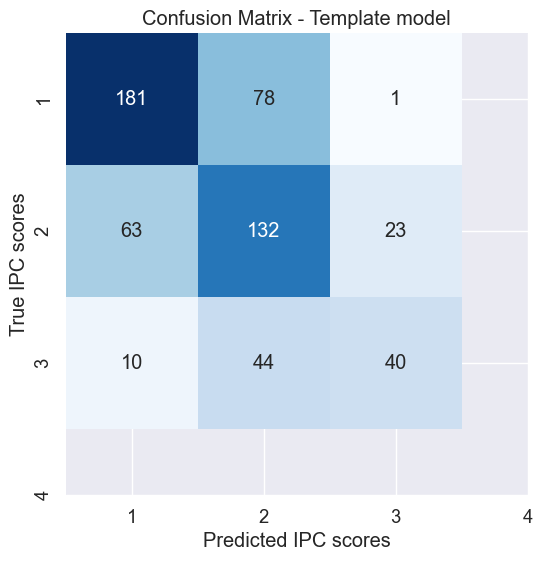

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     354.2
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:11:28   Log-Likelihood:                -1454.1
No. Observations:                2626   AIC:                             2930.
Df Residuals:                    2615   BIC:                             2995.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2147 

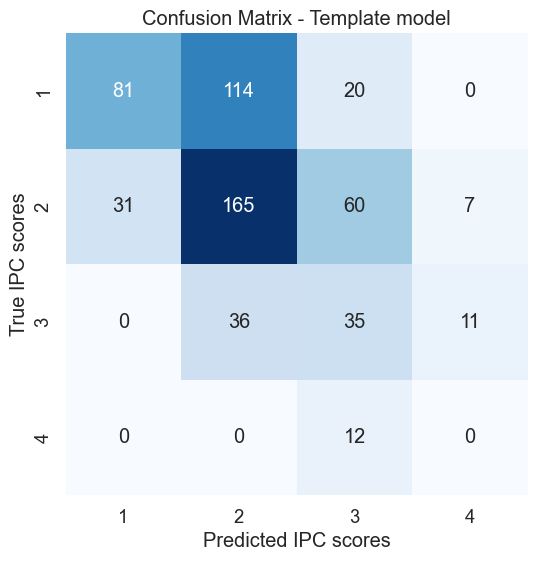

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     579.6
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:11:28   Log-Likelihood:                -2544.7
No. Observations:                4290   AIC:                             5111.
Df Residuals:                    4279   BIC:                             5181.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2626 

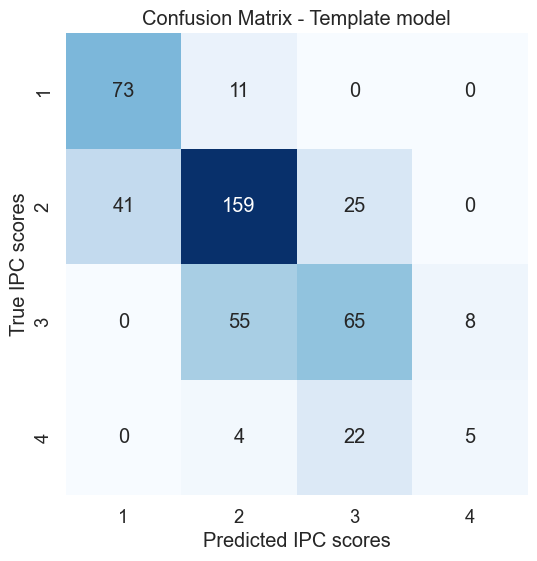

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     1081.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:11:28   Log-Likelihood:                -3580.7
No. Observations:                5954   AIC:                             7183.
Df Residuals:                    5943   BIC:                             7257.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1372 

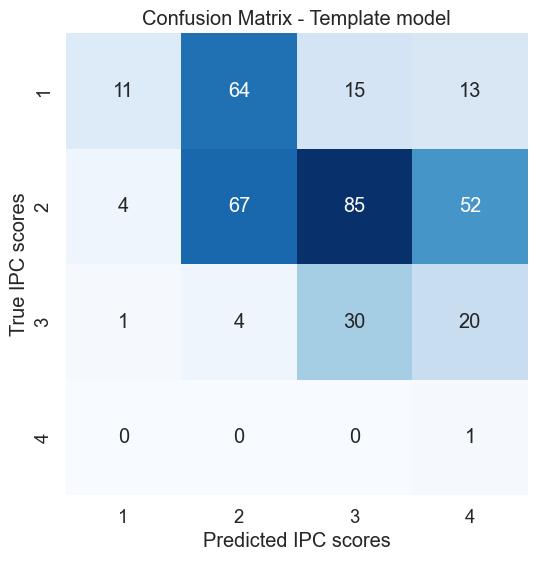

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     1800.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:11:29   Log-Likelihood:                -4784.2
No. Observations:                7618   AIC:                             9590.
Df Residuals:                    7607   BIC:                             9667.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1344 

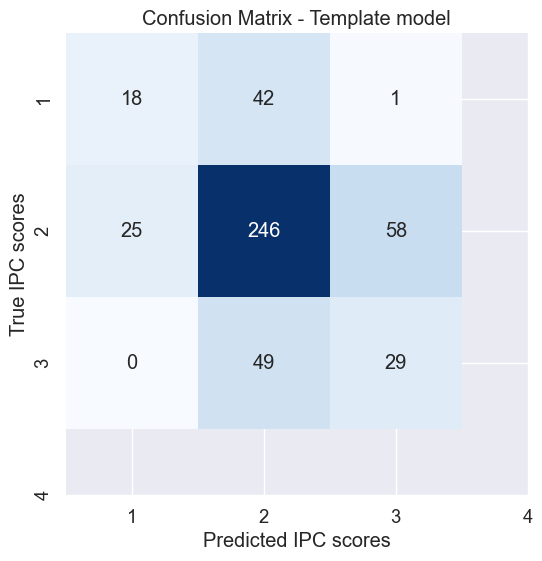

Mean MAE: 0.63
Mean R2: 0.62
Mean Accuracy: 53.18%
Mean Weighted F1: 0.536


In [4]:
template_model = model_eval(X = X_template, y = y_template, model_type = "OLS")

### 1.2 Ridge regression model

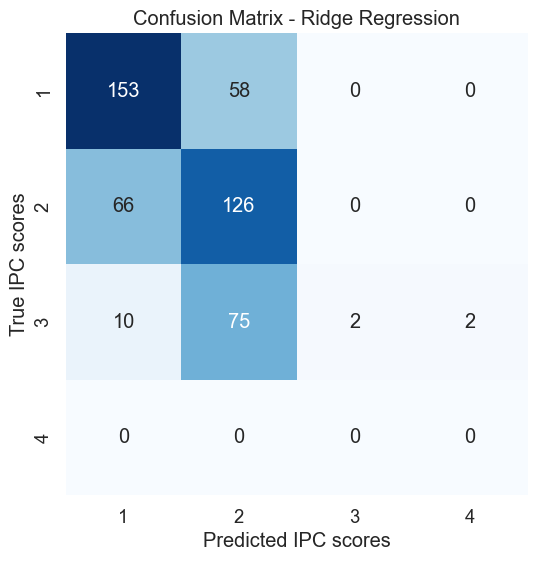

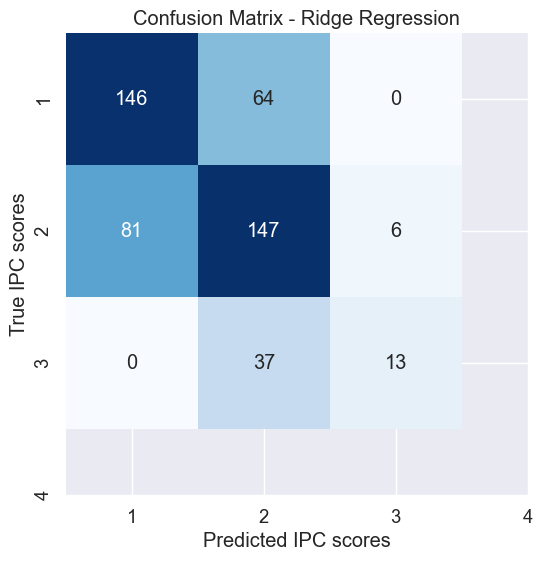

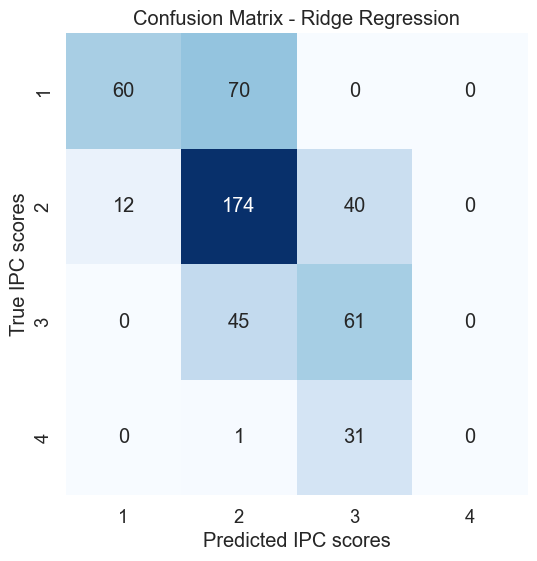

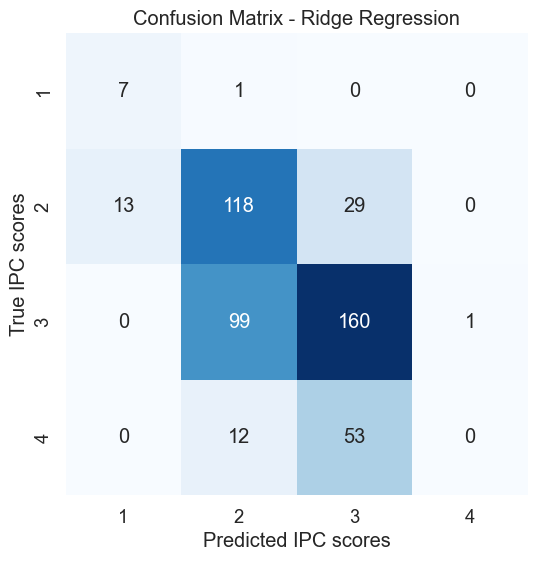

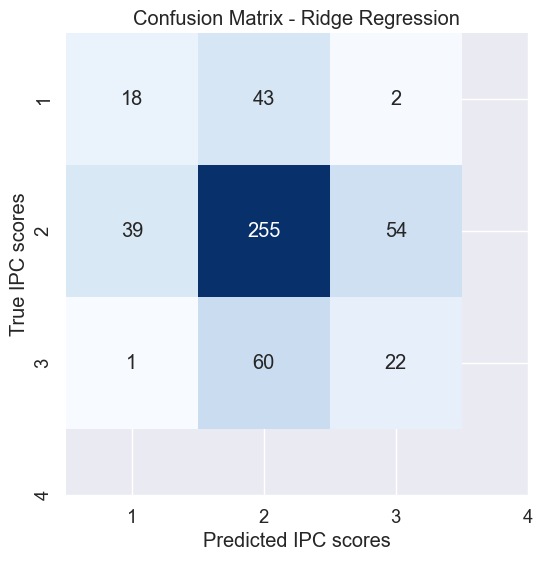

Mean MAE: 0.42
Mean R2: 0.45
Mean Accuracy: 59.19%
Mean Weighted F1: 0.568


In [5]:
Ridge_model = model_eval(X = X_improved, y = y_improved, model_type = "Ridge")

### 1.3 XGboost

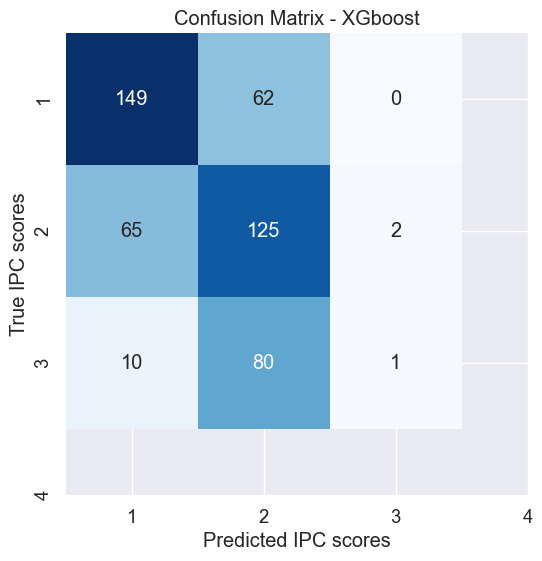

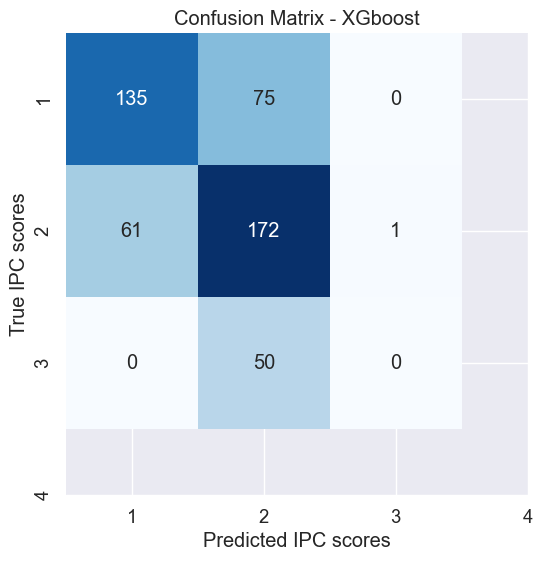

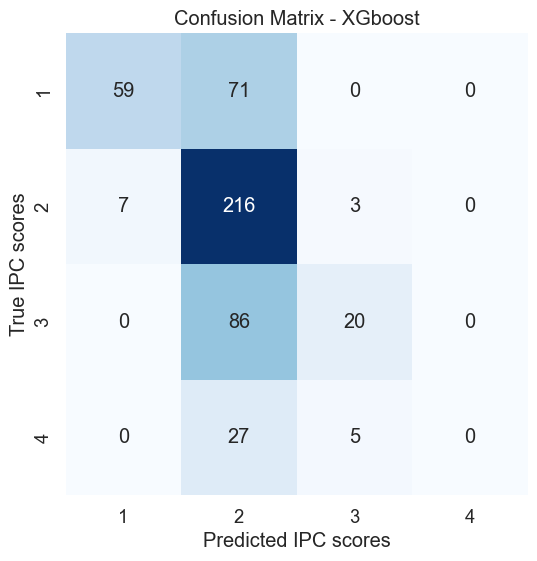

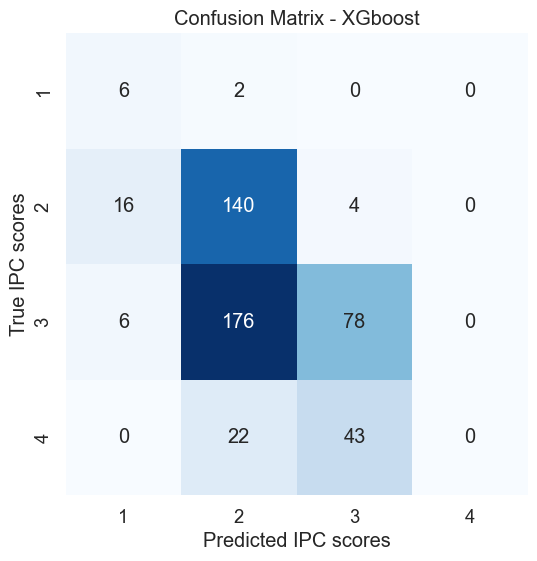

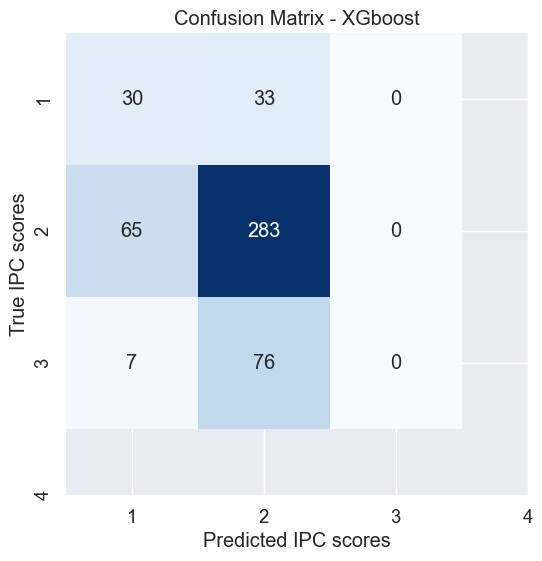

Mean MAE: 0.457
Mean accuracy: 57.25%
Mean weighted f1: 0.524


In [6]:
xgboost_model = model_eval(X = X_improved, y = y_improved, model_type = "XGboost")

### 1.4 NN default topics

Model Training:   0%|          | 0/1200 [00:00<?, ?it/s]

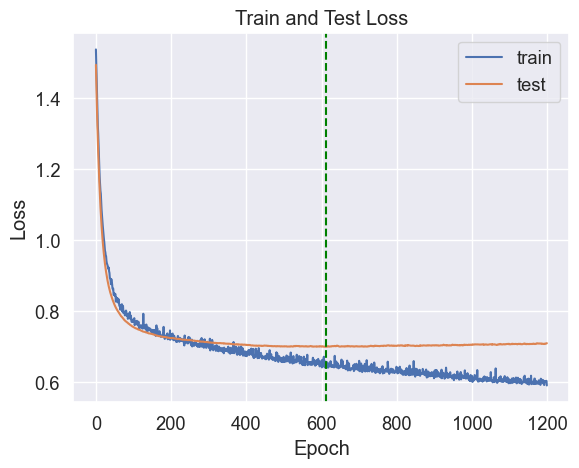

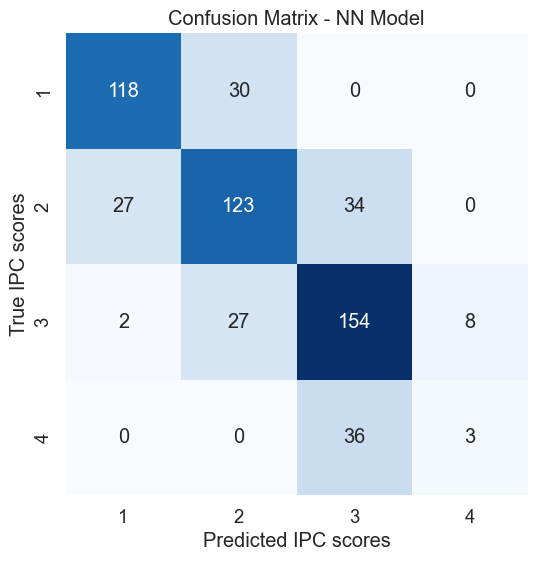

Mean Absolute Error (MAE): 0.29537366548042704
Accuracy: 0.708185053380783
F1 Score: 0.6925015395357976


In [7]:
NN_default_model, default_true_labels, default_predicted_probabilities, default_predicted_labels = model_eval(X = X_template,
                                                                                                              y = y_template,
                                                                                                              model_type = "NN")

### 1.5 Final NN

Model Training:   0%|          | 0/1200 [00:00<?, ?it/s]

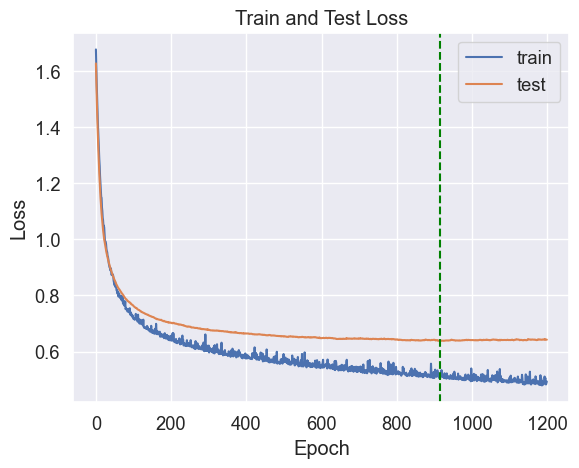

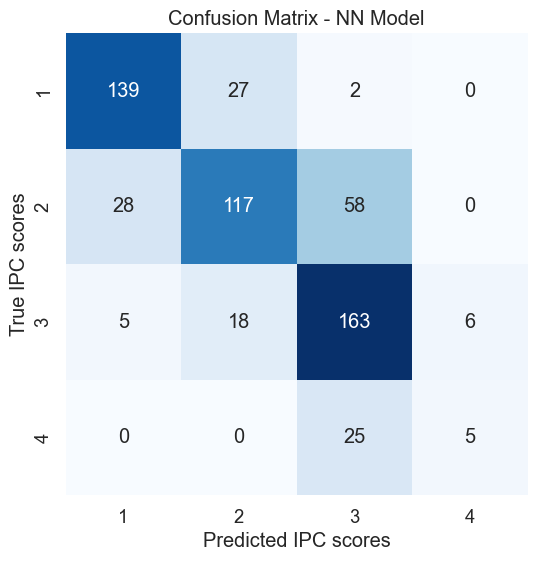

Mean Absolute Error (MAE): 0.29679595278246207
Accuracy: 0.715008431703204
F1 Score: 0.7033369144368545


In [8]:
NN_final_model, final_true_labels, final_predicted_probabilities, final_predicted_labels  = model_eval(X = X_improved,
                                                                                                       y = y_improved,
                                                                                                       model_type = "NN")

## 2. Article Utilization

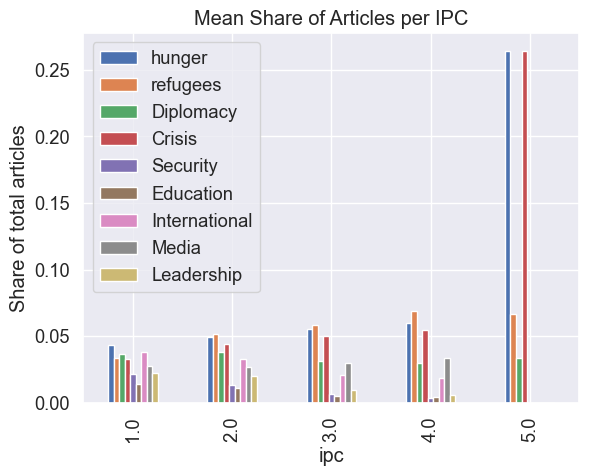

In [9]:
helper_functions.articles_per_ipc(y_template)

Preparing data for the Pie Chart:   0%|          | 0/18520 [00:00<?, ?it/s]

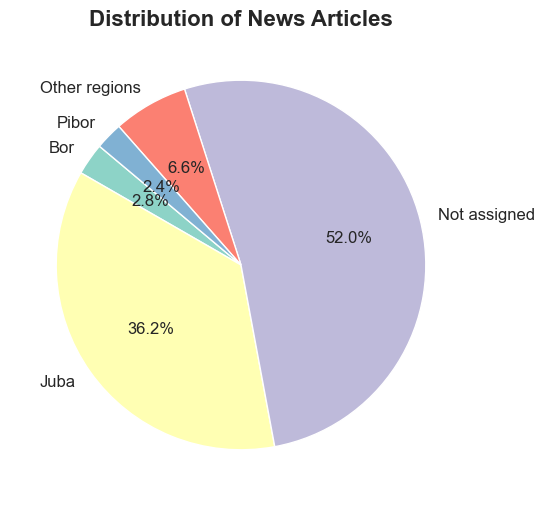

In [10]:
helper_functions.articles_per_region()

## 3. Bias Reduction

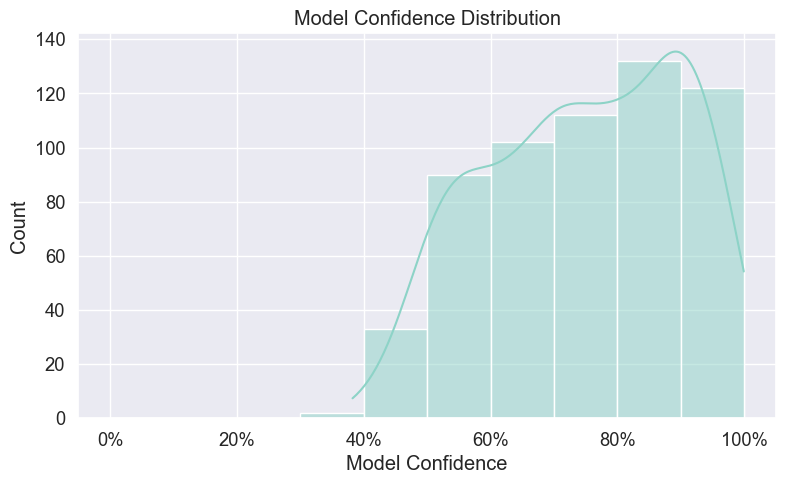

In [11]:
predict_prob_list = np.ndarray(len(final_predicted_probabilities))
predict_class_list = np.ndarray(len(final_predicted_probabilities))

for i in range(len(final_predicted_probabilities)):
    if i % 10 == 0:
        print()
    predict_prob_list[i] = final_predicted_probabilities[i].max()

df_confidence = pd.DataFrame({'true_val': final_true_labels, 'pred_val': final_predicted_labels, 'pred_prob': predict_prob_list})
df_confidence = df_confidence[(df_confidence['pred_prob'] > 0) & (df_confidence['pred_prob'] < 1)]

# Set the figure size
plt.figure(figsize=(9, 5))  # Adjust the width and height as needed
# Create your histogram plot
sns.histplot(df_confidence['pred_prob'], bins=[i/10 for i in range(11)], kde=True)

# Add xlabel, ylabel, and title
plt.xlabel('Model Confidence')
plt.ylabel('Count')
plt.title('Model Confidence Distribution')

# Update the x-axis tick labels to display every 20%
x_ticks = [i/5 for i in range(6)]  # 0.0, 0.2, 0.4, 0.6, 0.8, 1.0
x_labels = [f'{int(x*100)}%' for x in x_ticks]
plt.xticks(x_ticks, x_labels)
# Display the plot
plt.show()

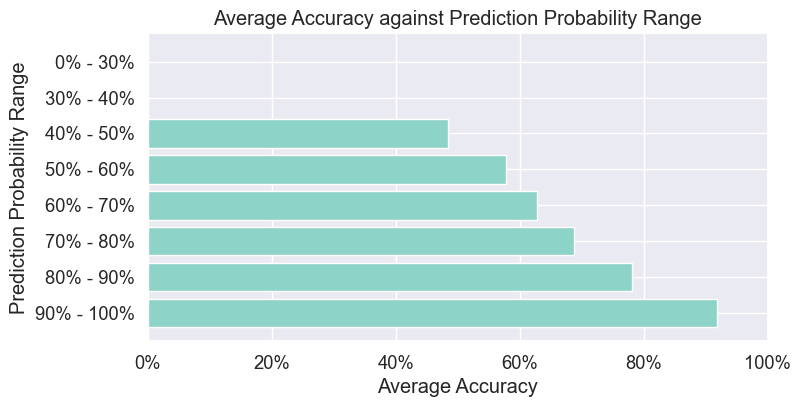

In [12]:
# Define the probability ranges
probability_ranges = [(1.0, 0.9), (0.9, 0.8), (0.8, 0.7), (0.7, 0.6), (0.6, 0.5), (0.5, 0.4), (0.4, 0.3), (0.3, 0.0)]

# Calculate accuracy for each probability range
accuracies = []
for range_start, range_end in probability_ranges:
    subset = df_confidence[(df_confidence['pred_prob'] >= range_end) & (df_confidence['pred_prob'] <= range_start)]
    if len(subset) > 0:
        accuracy = np.sum(subset['true_val'] == subset['pred_val']) / len(subset)
        accuracies.append(accuracy)
    else:
        accuracies.append(0.0)

# Create the histogram
plt.figure(figsize=(8, 4))
plt.barh([f"{int(range_end*100)}% - {int(range_start*100)}%" for range_start, range_end in probability_ranges], accuracies)
plt.xlabel('Average Accuracy')
plt.ylabel('Prediction Probability Range')
plt.title('Average Accuracy against Prediction Probability Range')
plt.xlim(0, 1)

# Define a function to format the x-axis ticks as percentages
def percentage_formatter(x, pos):
    return f"{int(x * 100)}%"

# Modify the x-axis ticks to display as percentages
x_ticks_percentages = [f"{int(x*100)}%" for x in plt.xticks()[0]]
plt.xticks(plt.xticks()[0], x_ticks_percentages)


plt.show()